# **Imports**


In [1]:
# Custom libraries
from tools.YOLODataLoader import YOLODataLoader
from tools.EDA import EDA
from tools.YOLOv9Trainer import YOLOv9Trainer
from tools.YOLOEvaluator import YOLOEvaluator


# Custom YOLO model
from models.YOLOv9Classifier import YOLOv9Classifier

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

print(torch.cuda.is_available())

2.4.1+cu118
0.19.1+cu118
11.8
True


# **Data Load**


In [3]:
# Инициализация YOLODataLoader с путями
yolo_loader = YOLODataLoader(
    train_dir="./db/train",
    val_dir="./db/valid",
    test_dir="./db/test",
    yaml_path="./db/data.yaml",
    batch_size=8,
    shuffle=True,
)

Classes loaded: ['door', 'cabinetDoor', 'refrigeratorDoor', 'window', 'chair', 'table', 'cabinet', 'couch', 'openedDoor', 'pole']


In [4]:
# Обновление путей в YAML
updated_yaml_path = yolo_loader.update_yaml_paths(
    yaml_path="./db/data.yaml",
    output_yaml_path="./db/updated_data.yaml",
)

YAML paths updated and saved to ./db/updated_data.yaml


In [5]:
print(f"Yolo DataLoader type: {type(yolo_loader)}")
print(f"Updated YAML path: {updated_yaml_path}")

Yolo DataLoader type: <class 'tools.YOLODataLoader.YOLODataLoader'>
Updated YAML path: ./db/updated_data.yaml


# **EDA**


In [6]:
eda = EDA(yolo_loader)

In [7]:
eda.show_dataset_statistics()

,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Mode
0,473,3178,689,403,204,228,179,27,78,27,train
1,96,765,192,91,49,40,32,1,13,9,valid
2,34,179,2,63,87,47,52,58,20,8,test


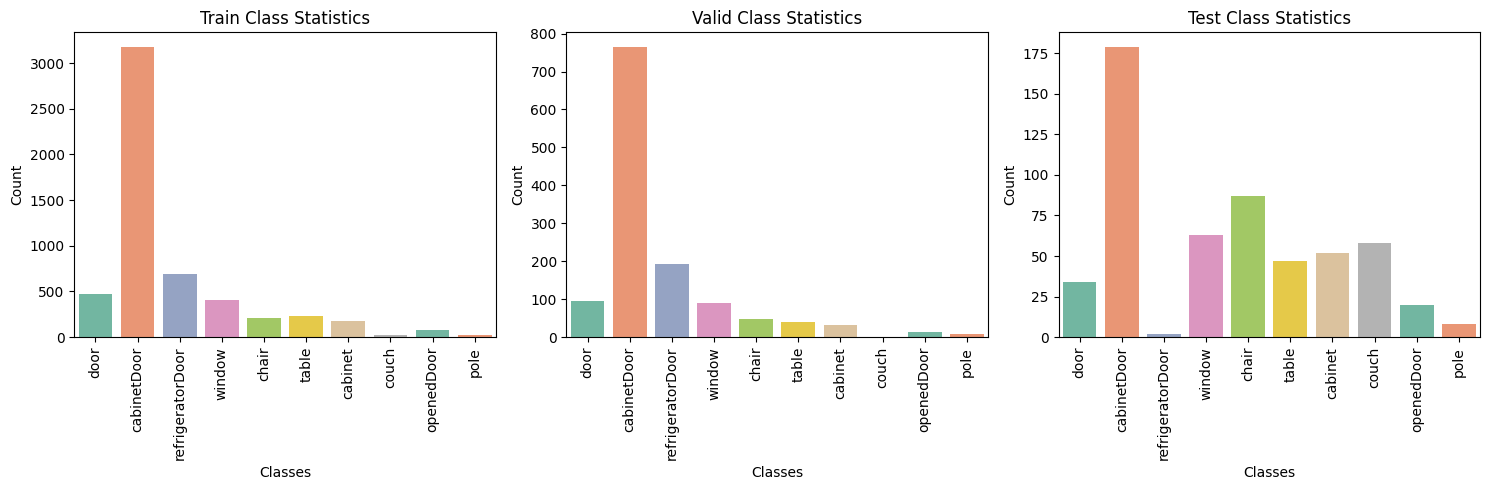

In [8]:
eda.plot_class_distribution()

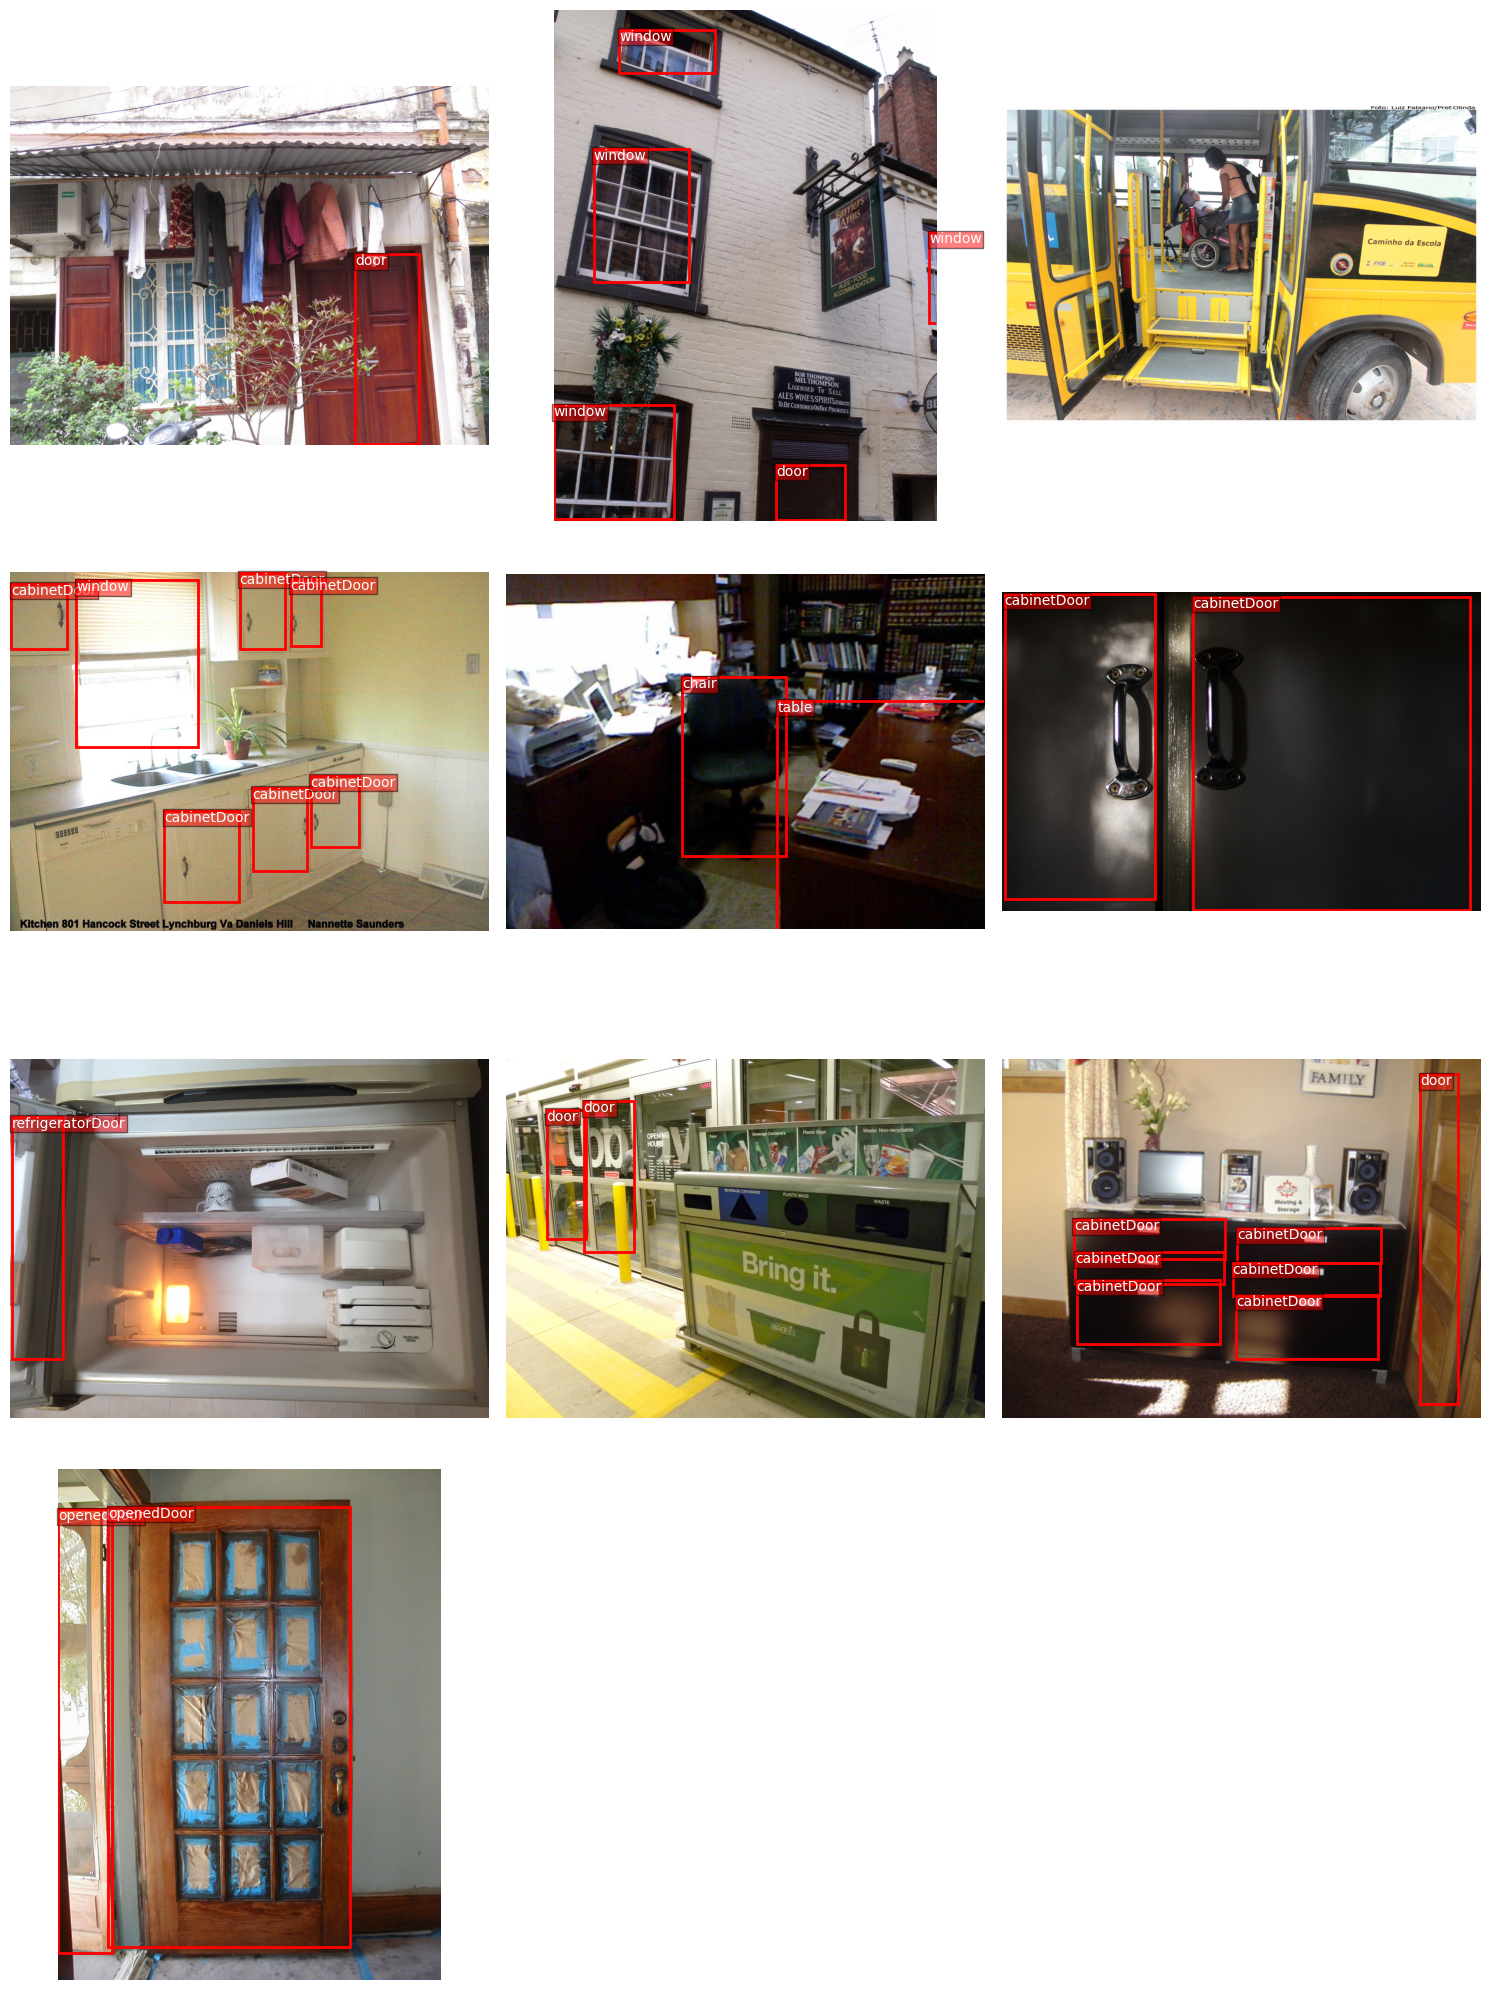

In [9]:
eda.show_sample_images(num_images=10, loader_type="train")

# **Modal Initialization**


In [10]:
yolo_model = YOLOv9Classifier(
    data_yaml=updated_yaml_path,
    task="detect",
    imgsz=(640, 640),
    model_name="yolov9e.pt",  # YOLOv9 model file
    device="cuda",  # Устройство для тренировки
    random_state=42,  # Seed для воспроизводимости
    profile=False,  # Профилирование
    label_smoothing=0.0,  # Сглаживание меток
    exp_name="experiment",  # Название эксперимента
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    verbose=True,
    output_dir="./res/"
)

In [11]:
param_grid = {
    "epochs": [3],  # Количество эпох для обучения
    "batch_size": [4],  # Размер пакета для обучения
    "optimizer_type": ["auto"],  # Тип оптимизатора
    "lr": [1e-3],  # Начальная скорость обучения
    "lrf": [0.01],  # Коэффициент для планировщика learning rate
    "patience": [20],  # Количество эпох для раннего останова
    "weight_decay": [5e-4],  # Весовой коэффициент регуляризации
    "dropout": [0.0],  # Dropout для регуляризации
    "fraction": [0.5],  # Доля данных для обучения -- 1
}

In [12]:
models = {"yolo_model": yolo_model}
param_grids = {"yolo_model": param_grid}

# **Model Training**


In [13]:
trainer = YOLOv9Trainer(device="cuda")

In [14]:
trainer.train(models=models, param_grids=param_grids)

Training on device: cuda

Training yolo_model with parameters: {'batch_size': 4, 'dropout': 0.0, 'epochs': 3, 'fraction': 0.5, 'lr': 0.001, 'lrf': 0.01, 'optimizer_type': 'auto', 'patience': 20, 'weight_decay': 0.0005}
Ultralytics YOLOv8.2.98  Python-3.12.3 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=./db/updated_data.yaml, epochs=3, time=None, patience=20, batch=4, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cuda, workers=8, project=./res/, name=experiment, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.5, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=

train: Scanning C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\train\labels... 505 images, 39 backgrounds, 0 corrupt: 100%|██████████| 506/506 [00:00<00:00, 1693.07it/s]

train: New cache created: C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\train\labels.cache



val: Scanning C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\valid\labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to res\experiment\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to res\experiment
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/127 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 600.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 220.75 MiB is free. Of the allocated memory 2.91 GiB is allocated by PyTorch, and 74.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
best_models = trainer.best_estimators
best_params = trainer.best_params
best_scores = trainer.best_scores
best_model_name = trainer.best_model_name
best_model = best_models[best_model_name]

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)
print(best_model)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x000002345AF647D0>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}}
{'cnn_model': 0.781744335185977}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = YOLOEvaluator(output_dir=best_model.output_dir, exp_name=best_model.exp_name, device=best_model.device)

In [29]:
# evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─AvgPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─AvgPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─AvgPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           27,558,144
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 27,685,062
Trainable params: 27,685,062
Non-trainable params: 0


In [30]:
# evaluator.display_results(
#     test_dataset=transformed_test_dataset,
#     best_models=best_models,
#     best_params=best_params,
#     best_scores=best_scores,
#     best_model_name=best_model_name,
#     help_text=True,
# )

Validation Loss: 0.43439963827791445, Validation Accuracy: 0.836
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.836,0.839186,0.83615,0.841536,0.836



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.781744



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


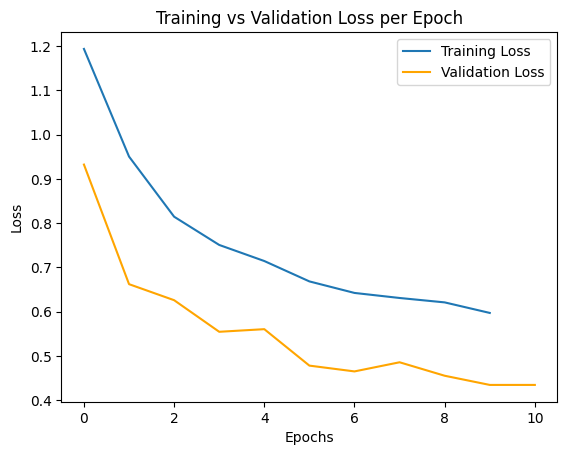

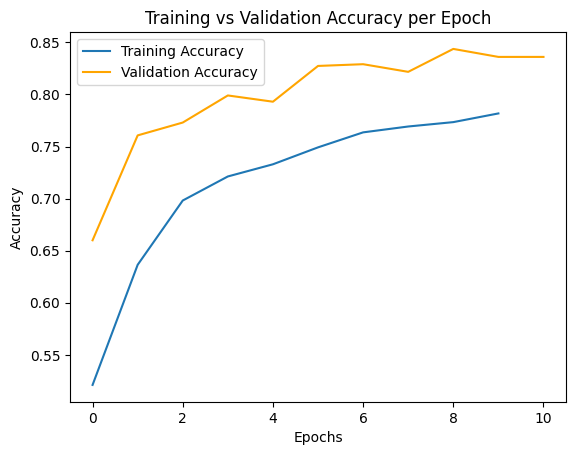

In [31]:
# evaluator.plot_loss_history(best_models, best_model_name)
# evaluator.plot_accuracy_history(best_models, best_model_name)

In [32]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions:**

# **High Model Accuracy:**

**Validation Accuracy:** The model achieved a validation accuracy of 88.5%. This suggests that the model generalizes well to unseen data, predicting the correct outcomes in most cases during validation.

**Evaluation on Test Set:** The model achieved an accuracy of 0.885 on the test set. Furthermore, additional evaluation metrics such as:

**Balanced Accuracy:** 0.8860

**F1 Score:** 0.8840

**Precision:** 0.8882

**Recall:** 0.8850

These metrics indicate that the model performs consistently well across various evaluation aspects, demonstrating a strong balance between precision and recall.

# **Optimal Hyperparameters:**

**Best Architecture:** The optimal architecture consisted of 3 convolutional layers with the following configuration: [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]. This design proved to be effective for feature extraction and subsequent classification tasks.

**Hyperparameter Tuning: The best model was obtained with:**

**Batch size:** 16
**Learning rate:** 0.001
**ReLU activation function**
**Adam optimizer**

The inclusion of a dropout rate of 0.1 helped to prevent overfitting during training. The model used AvgPooling (kernel size = 2, stride = 2, padding = 1) to reduce the spatial dimensions while preserving the most important features.

# **Regularization and Loss Function:**

**Regularization:** The use of dropout after each hidden layer (with a dropout rate of 0.1) proved effective in mitigating overfitting, acting as a regularization method by randomly dropping units during training. This added stochasticity helps to improve the model's generalization ability.

**Optimizer and Loss Function:** The Adam optimizer, combined with cross-entropy loss, was instrumental in effectively optimizing the model. This combination provided a balance between fast convergence and stable gradient updates.

# **Cross-Validation Score:**

The cross-validation score for the best model was 0.843, indicating strong generalization across different data splits. While the model performed well during both cross-validation and on the test set, there remains a small gap between training and validation scores, suggesting that further fine-tuning or additional regularization techniques could still offer marginal improvements.
